In [1]:
import os
from tqdm import tqdm
from srutils import ImageDataset, compare_model, save_val_images

import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
small_patch_size = 128

In [4]:
train_dataset_dir = '../DIV2K_HR_Train/'
val_dataset_dir = '../DIV2K_HR_Val/'

train_dataset = ImageDataset(train_dataset_dir, small_patch_size)
train_dataloader = DataLoader(train_dataset, batch_size = 5, shuffle=True)

In [5]:
log_dir='runs/esrgan/'
tbwriter = SummaryWriter(log_dir)

In [6]:
gen_rrdb_layers = 8
gen_residual_scaling = 0.2

In [7]:
class ShuffleBlock(nn.Module):

    def __init__(self):
           
        super().__init__()
        layers = [nn.Conv2d(in_channels = 64,
                                  out_channels = 256,
                                  kernel_size = 3,
                                  padding = 1),
                nn.PixelShuffle(2),
                nn.PReLU()] * 2

        self.net = nn.Sequential(*layers)

    def forward(self, x):

        return self.net(x)

In [8]:
class RRDB(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv = nn.ModuleList([nn.Conv2d(in_channels = 64,
                               out_channels = 64,
                               kernel_size = 3,
                               padding = 1)
                    for _ in range(5)])
        self.act = nn.ModuleList([nn.PReLU() for _ in range(4)])

    def forward(self, x):

        block0 = self.conv[0](x)
        block0 = self.act[0](block0)

        block1 = x + block0
        block1 = self.conv[1](block1)
        block1 = self.act[1](block1)

        block2 = x + block0 + block1
        block2 = self.conv[2](block2)
        block2 = self.act[2](block2)

        block3 = x + block0 + block1 + block2
        block3 = self.conv[3](block3)
        block3 = self.act[3](block3)

        block4 = x + block0 + block1 + block2 + block3
        block4 = self.conv[4](block4)
        block4 = gen_residual_scaling * block4

        return block4

In [9]:
class Generator(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv0 = nn.Conv2d(in_channels = 3,
                               out_channels = 64,
                               kernel_size = 3,
                               padding = 1)

        self.residuals = nn.Sequential(
            *[RRDB() for _ in range(gen_rrdb_layers)])

        self.conv1 = nn.Conv2d(in_channels = 64,
                               out_channels = 64,
                               kernel_size = 3,
                               padding = 1)

        self.shuf = ShuffleBlock()

        self.conv2 = nn.Conv2d(in_channels = 64,
                               out_channels = 64,
                               kernel_size = 3,
                               padding = 1)

        self.conv3 = nn.Conv2d(in_channels = 64,
                               out_channels = 3,
                               kernel_size = 9,
                               padding = 4)
        self.act1 = nn.Tanh()

    def forward(self, x):

        pre_block = self.conv0(x)
        block = self.residuals(pre_block)
        block = gen_residual_scaling * block
        block = self.conv1(block)
        block = pre_block + block
        block = self.shuf(block)
        block = self.conv2(block)
        block = self.conv3(block)
        block = self.act1(block)

        return block

In [10]:
class DiscBlock(nn.Module):

    def __init__(self, in_filters, out_filters, stride):

        super().__init__()
        self.conv = nn.Conv2d(in_channels = in_filters,
                              out_channels = out_filters,
                              kernel_size = 3,
                              padding = 1,
                              stride = stride)
        self.norm = nn.BatchNorm2d(num_features = out_filters)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):

        block = self.conv(x)
        block = self.norm(block)
        block = self.act(block)

        return block

In [11]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__() 
        self.conv0 = nn.Conv2d(in_channels = 3,
                               out_channels = 64,
                               kernel_size = 3,
                               padding = 1)
        self.act0 = nn.LeakyReLU(0.1)
        self.convblock0 = DiscBlock(in_filters = 64,
                                   out_filters = 64,
                                   stride = 2)
        self.convblock1 = DiscBlock(in_filters = 64,
                                   out_filters = 128,
                                   stride = 1)
        self.convblock2 = DiscBlock(in_filters = 128,
                                   out_filters = 128,
                                   stride = 2)
        self.convblock3 = DiscBlock(in_filters = 128,
                                   out_filters = 256,
                                   stride = 1)
        self.convblock4 = DiscBlock(in_filters = 256,
                                   out_filters = 256,
                                   stride = 2)
        self.conv1 = nn.Conv2d(in_channels = 256,
                               out_channels = 1,
                               kernel_size = 3,
                               padding = 1)

    def forward(self, x):

        block = self.conv0(x)
        block = self.act0(block)
        block = self.convblock0(block)
        block = self.convblock1(block)
        block = self.convblock2(block)
        block = self.convblock3(block)
        block = self.convblock4(block)
        block = self.conv1(block)

        return block

In [12]:
warmup_batches = 50

# Not the parameters from paper
# Need to be tuned
adversarial_loss_coef = 0.001
mse_loss_coef = 1
vgg_loss_coef = 0.006

loss_BCE = nn.BCEWithLogitsLoss().to(device)
loss_MSE = nn.MSELoss().to(device)

In [13]:
def train_step(epoch):

    train_data_iterator = iter(train_dataloader)
    for step, (x, y) in enumerate(train_data_iterator):

        total_step = epoch * len(train_dataloader) + step

        x, y = x.to(device), y.to(device)

# Train the Generator
        
        generator_optimizer.zero_grad()
        generated_images = generator.forward(x)  
        mse_loss = loss_MSE(generated_images, y) * mse_loss_coef

# Train using MSE Loss only if still in warmup batches
        
        if total_step < warmup_batches:

            mse_loss.backward()
            generator_optimizer.step()
            
            tbwriter.add_scalars('generator',{'MSE':mse_loss,
                                      'VGG':0,
                                      'Adv':0,
                                      'Total':mse_loss},
                                    total_step)
            tbwriter.add_scalars('discriminator',{'Real':0,
                                      'Fake':0,
                                      'Total':0},
                                 total_step)
            continue

# Train using VGG and Adversarial Loss if past warmup batches
        
        vgg_loss = loss_MSE(vgg(generated_images), vgg(y)) * vgg_loss_coef 

        disc_generated_predictions = discriminator(generated_images)
        disc_real_predictions = discriminator(y)
        real_labels = torch.ones_like(disc_generated_predictions).to(device)
        
        adversarial_loss = loss_BCE(disc_generated_predictions - \
                                    disc_real_predictions.mean(),
                                    real_labels)
        adversarial_loss = adversarial_loss * adversarial_loss_coef

        gen_loss = mse_loss + vgg_loss + adversarial_loss
        (gen_loss).backward()
        generator_optimizer.step()

# Train the Discriminator if past warmup batches
        
        discriminator_optimizer.zero_grad() 
        fake_images = generator(x)
        
        discriminator_fake_predictions = discriminator(fake_images)
        discriminator_real_predictions = discriminator(y)

        fake_labels = torch.zeros_like(discriminator_fake_predictions).to(device)
        disc_fake_loss = loss_BCE(discriminator_fake_predictions -\
                                  discriminator_real_predictions.mean(),
                                  fake_labels)
        
        real_labels = torch.ones_like(discriminator_real_predictions).to(device)
        disc_real_loss = loss_BCE(discriminator_real_predictions -\
                                  discriminator_fake_predictions.mean(),
                                  real_labels)
        
        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()          
        discriminator_optimizer.step()
        
        tbwriter.add_scalars('discriminator',{'Real':disc_real_loss,
                                              'Fake':disc_fake_loss,
                                              'Total':disc_loss},
                                         total_step)

        tbwriter.add_scalars('generator',{'MSE':mse_loss,
                                          'VGG':vgg_loss,
                                          'Adv':adversarial_loss,
                                          'Total':gen_loss},
                                        total_step)

In [14]:
vgg = models.vgg19(weights='DEFAULT').features[:35].to(device)
for param in vgg.parameters():
    param.requires_grad = False

In [15]:
generator_lr = 2e-4

generator = Generator()
generator.to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(),
                                       lr = generator_lr)

In [16]:
discriminator_lr = 2e-4

discriminator = Discriminator()
discriminator.to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr = discriminator_lr)

In [17]:
epochs = 0

for epoch in tqdm(range(epochs)):
    train_step(epoch)

0it [00:00, ?it/s]


In [18]:
#torch.save(generator,'savedmodels/ESRGAN/gen.pth')

In [19]:
generator = torch.load('savedmodels/ESRGAN/gen.pth')

In [20]:
save_val_images(generator, val_dataset_dir, 0, 'esr', save_all = False)

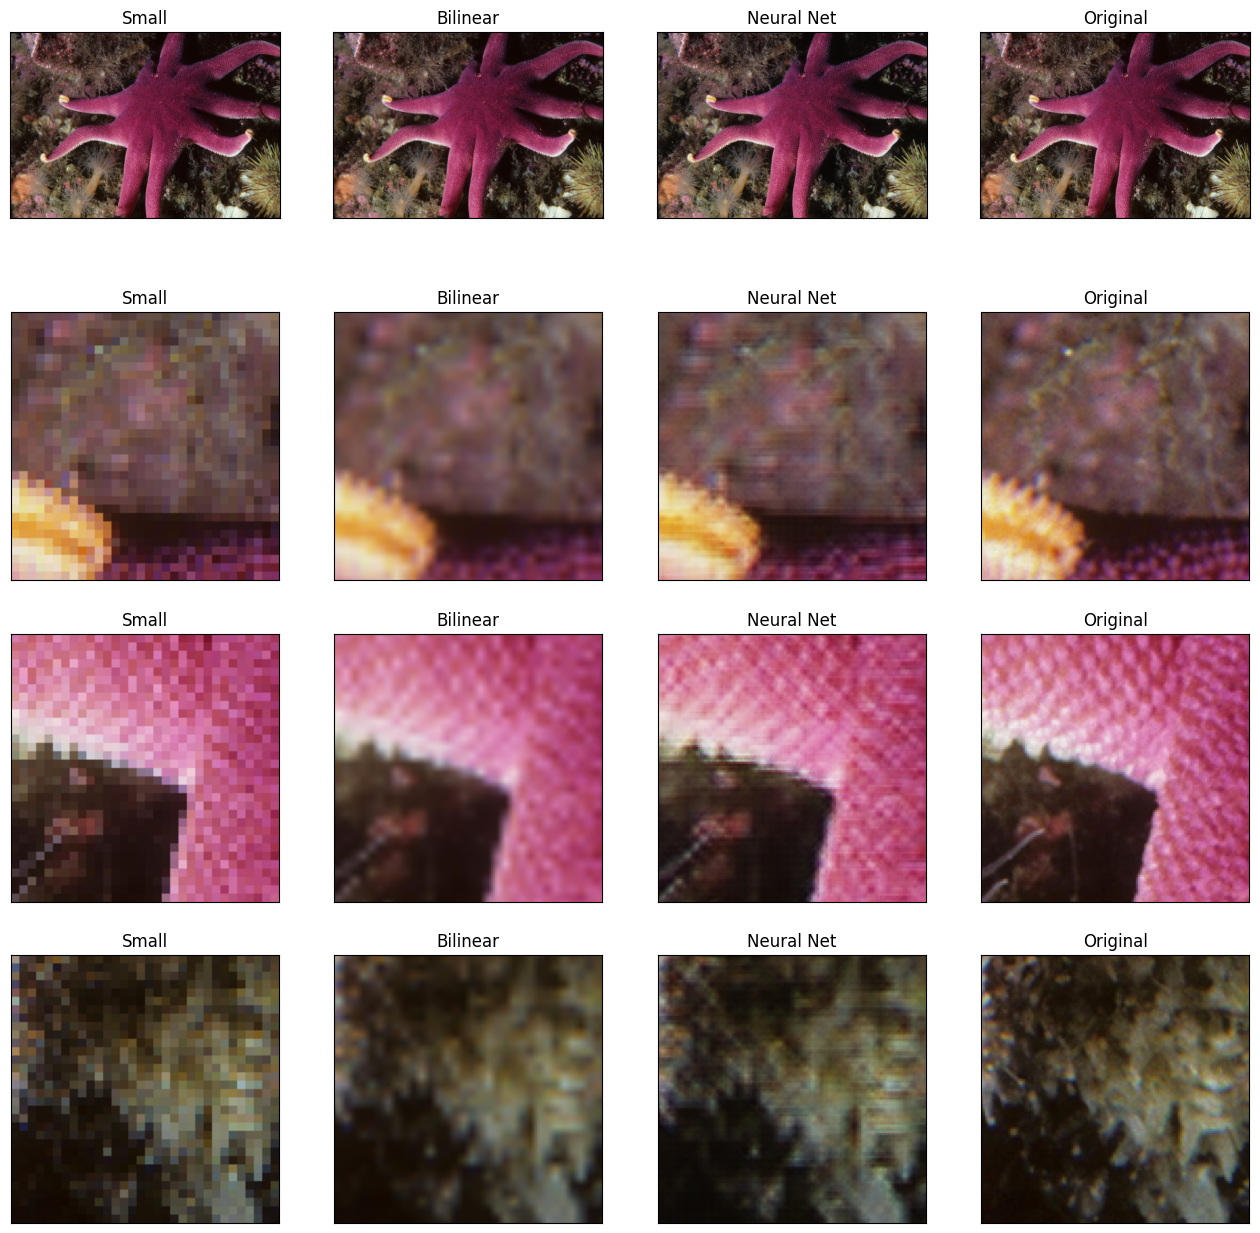

In [21]:
compare_model(generator, train_dataset_dir, 0);

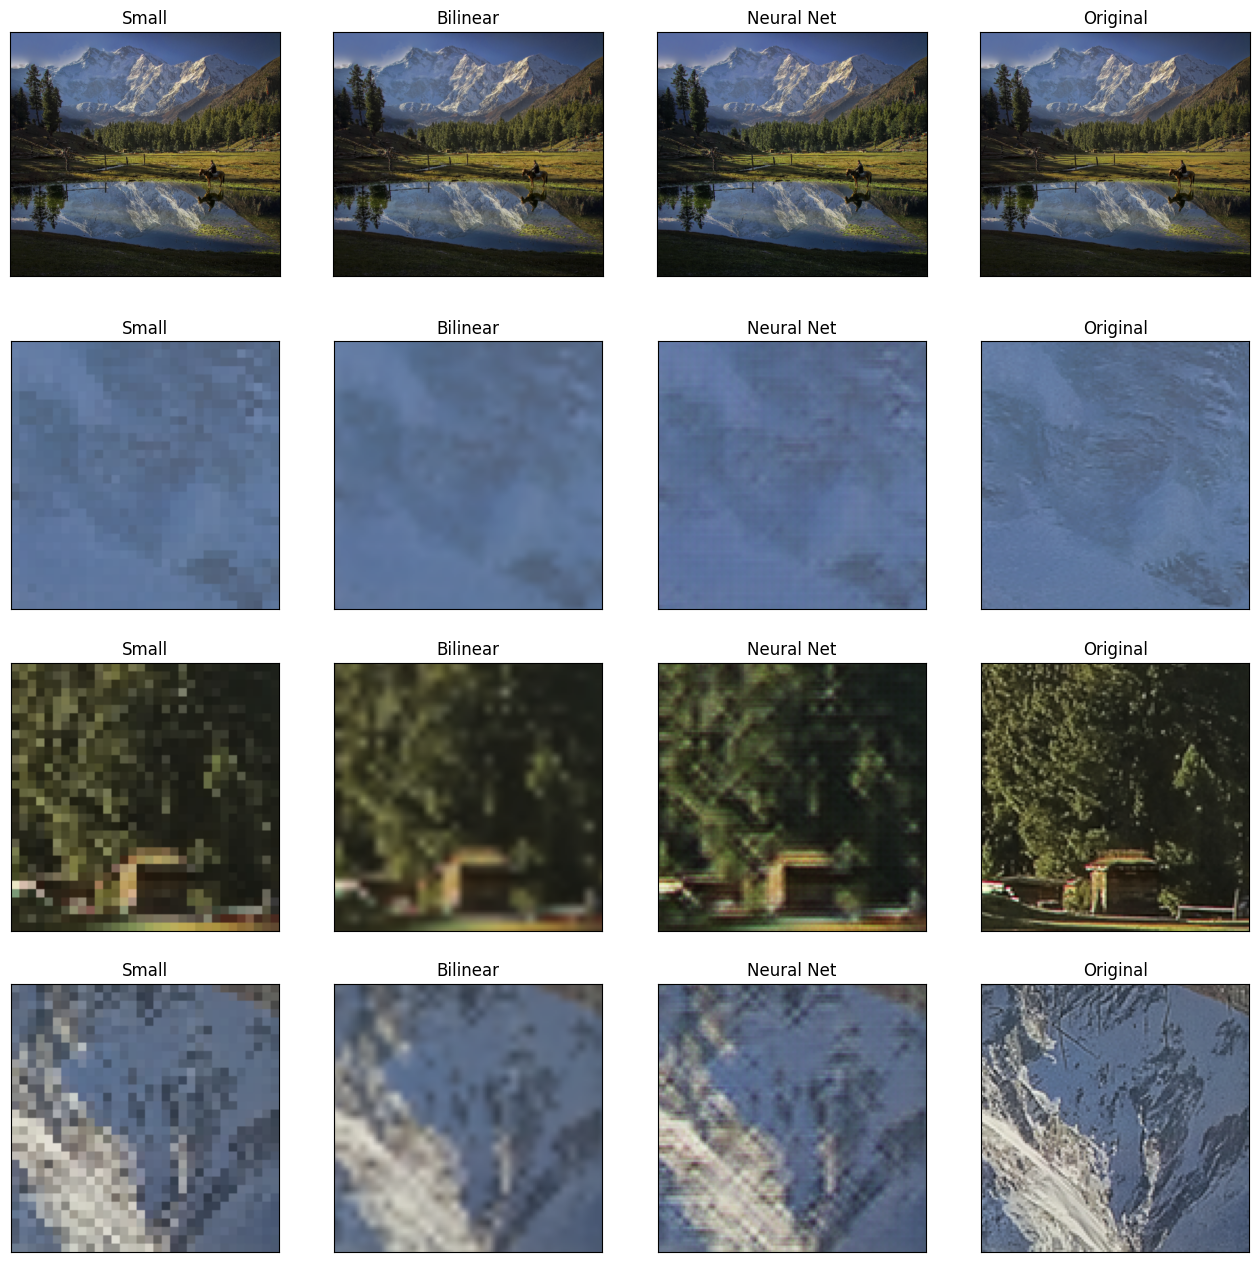

In [22]:
compare_model(generator, train_dataset_dir, 1);